In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

### Import Word2Vec document vectors

In [3]:
#wv_matrix = np.load(open("../processed_files/wv_matrix.npy", "rb"), allow_pickle = True)
df_merged = pickle.load(open("../processed_files/df_merged.pickle", "rb"))

In [4]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PARSED
0,0-my.com,0-my.com related searches: related searches:,-my.com related searches: related searches:
1,00bitz.com,error. page cannot be displayed. please contac...,error. page cannot be displayed. please contac...
2,01187.com,01187.com is available for purchase! - wwwv1.c...,.com is available for purchase! - wwwv.com wel...
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...",".ir - dns.ir .ir hits: , under construction co..."
4,03h.org,february | 2014 | online marketing review sear...,february | | online marketing review search f...


In [5]:
df_merged.shape

(12956, 3)

In [6]:
wv_matrix = np.load("../processed_files/wv_matrix.npy", allow_pickle = True)

In [7]:
wv_matrix.shape

(12956, 300)

In [8]:
wv_matrix

array([[-0.04667969,  0.01650391, -0.08078613, ...,  0.03076172,
        -0.08239746,  0.04365234],
       [ 0.01216888,  0.06266785, -0.05297089, ..., -0.14987183,
        -0.02406311,  0.04301262],
       [-0.00084471,  0.01671178, -0.02623978, ..., -0.0320005 ,
        -0.05707883, -0.02600661],
       ...,
       [-0.0359158 , -0.01600477, -0.01171875, ..., -0.00710042,
        -0.08133782,  0.01126819],
       [-0.06754196,  0.02577789, -0.01776587, ..., -0.00946277,
        -0.06788616,  0.07699324],
       [-0.01781464, -0.17077637,  0.003479  , ..., -0.03669739,
        -0.13844299,  0.06338501]])

## word2vec

In [9]:
from sklearn.preprocessing import normalize
wv_matrix = normalize(wv_matrix, norm='l2', axis=1)


In [10]:
%%time
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(wv_matrix)
distances, indices = nbrs.kneighbors(wv_matrix)

CPU times: user 1min 16s, sys: 75.7 ms, total: 1min 16s
Wall time: 1min 16s


In [34]:
print(distances.shape)
print(indices.shape)

(12956, 20)
(12956, 20)


In [35]:
distances[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [36]:
indices[0]

array([ 3925,  8682,  7410,  4119,  4000,  7384,  3962,  4093,  3963,
        3253,  4002,  4027,     0,  7171,  3211,  3944, 11660,  3968,
        3996,  8588])

In [49]:
import statistics

def intracluster_similarity(index):
    cluster_centroid = wv_matrix[index]
    dist_list = []
    for i in indices[index][1:]:
        distance = np.linalg.norm(cluster_centroid-wv_matrix[i])
        dist_list.append(distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)
    
    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    #print('variance:', variance)
    
    return avg, variance

In [54]:
intracluster_similarity(35)

(0.06824707182972564, 0.0006050206643742883)

In [39]:
def generate_raw_content_cluster_df(index):
    index_list = list(indices[index])
    distance_list = list(distances[index])
    cluster_seed = df_merged.loc[index].to_frame().T
    cluster_seed['DISTANCE'] = 0
    cluster_df = df_merged.loc[index_list[1:]]
    cluster_df['DISTANCE'] = distance_list[1:]
    combined = pd.concat([cluster_seed, cluster_df.sort_values(by='DISTANCE', ascending=True)])
    return combined.style.set_properties(subset=['RAW_CONTENT'], **{'width-min': '100px'})
    #return combined

In [43]:
# non-unique index errors
# 14 is a good example
# 21 can we stop output after distance goes from 3 to 10.583?
# 22 is lots of similar basic e
generate_raw_content_cluster_df(124)

In [87]:
avg_list = []
variance_list = []

for i in range(wv_matrix.shape[0]):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x13a85d2e8>,
 <a list of 11 Text xticklabel objects>)

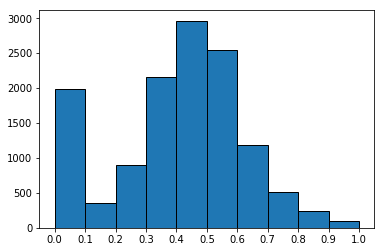

In [88]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x13a321898>,
 <a list of 11 Text xticklabel objects>)

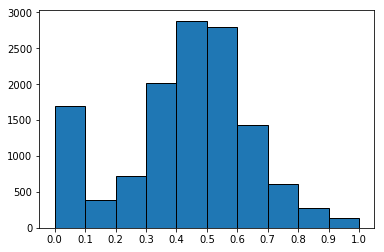

In [56]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x13a3711d0>,
 <a list of 11 Text xticklabel objects>)

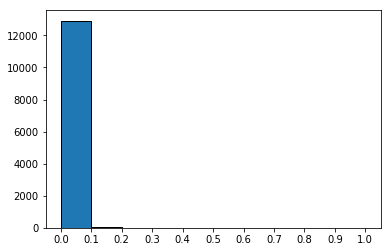

In [89]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x139dae3c8>,
 <a list of 11 Text xticklabel objects>)

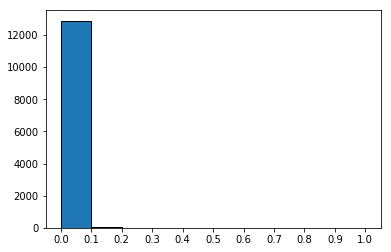

In [57]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

In [60]:
print(len(avg_list), len(variance_list))

12956 12956


## Intercluster Similarity

In [61]:
def calculate_centroid(index):
    cluster_centroid = wv_matrix[index]
    for i in indices[index][1:]:
        cluster_centroid = np.add(cluster_centroid, wv_matrix[i])
    return cluster_centroid/len(indices[index][1:])

In [90]:
index_centroid = dict()
for i in range(wv_matrix.shape[0]):
    index_centroid[i] = calculate_centroid(i)

In [64]:
index_centroid[0]

In [24]:
#centroid_centroid_distance = {}
#for i in range(wv_matrix.shape[0]):
#    centroid_centroid_distance[i] = {}
#    for j in range(wv_matrix.shape[0]):
#        if i < j:
#            centroid_centroid_distance[i][j] = np.linalg.norm(index_centroid[i]-index_centroid[j])

In [25]:
#centroid_centroid_distance

In [70]:
from random import sample
def sample_mean_intercluster_dist(sample_size):
    indices_sample = sample(range(wv_matrix.shape[0]),sample_size)
    centroid_centroid_distance = {}
    for i in indices_sample:
        for j in indices_sample:
            if i < j:
                key = str(i) + "::" + str(j)
                centroid_centroid_distance[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
    return np.array(list(centroid_centroid_distance.values())).mean()

# neighbors = 10

## 10 documents sample

In [91]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[0.7891214852780158, 0.5555958606171659, 0.7755108121727257, 0.8384253893498615, 0.8846783396045813]

0.7686663774044701


## 100 documents sample

In [92]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[0.7638435702579378, 0.746892656374703, 0.7257292290235408, 0.7316764766830107, 0.7614040570010219]

0.7459091978680428


## 500 documents sample

In [93]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[0.7361338102230409, 0.77923240233094, 0.7605507831964357, 0.7531352626895449, 0.7609279432954096]

0.7579960403470741


# neighbors = 20

## 10 documents sample

In [83]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[0.7379223294266803, 0.6196508662263486, 0.6354927717161413, 0.5526139849513789, 0.6944676267325679]

0.6480295158106235


## 100 documents sample

In [84]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[0.682738646752262, 0.6136167926138726, 0.7256810548560488, 0.6933414247928584, 0.7121724683773151]

0.6855100774784714


## 500 documents sample

In [85]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[0.6905119878746875, 0.6756116033955518, 0.697117863032606, 0.6781691871195568, 0.6948857332551986]

0.6872592749355202
